# Sentiment Analysis: Twitter vs Amazon Review Data

This notebook compares different sentiment analysis models on Twitter and Amazon datasets.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from copy import deepcopy
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, recall_score, f1_score, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention, GlobalAveragePooling1D
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Data Loading

In [2]:
amazon_data = pd.read_csv('amazon_reviews.csv')
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [3]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [4]:
amazon_data.duplicated().sum()

np.int64(0)

In [5]:
amazon_data.isnull().sum()

,0
Unnamed: 0,0
reviewerName,1
overall,0
reviewText,1
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


In [6]:
amazon_data.dropna(subset=['reviewerName', 'reviewText'], inplace=True)

amazon_data.drop_duplicates(subset=['reviewText'], keep='first', inplace=True)
amazon_data.reset_index(drop=True, inplace=True)

display(amazon_data.head())
print(amazon_data.shape)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0


(4912, 12)


In [7]:
def categorize_sentiment(row):
    if row['overall'] > 3:
        return 'positive'
    elif row['overall'] < 3:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the 'type' column
amazon_data['type'] = amazon_data.apply(categorize_sentiment, axis=1)

# Display the first few rows to verify the new column
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive


In [8]:
df = deepcopy(amazon_data)
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive


In [9]:
df['type'].value_counts()

,count
type,
positive,4446
negative,324
neutral,142


In [10]:
df.isnull().sum()

,0
Unnamed: 0,0
reviewerName,0
overall,0
reviewText,0
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


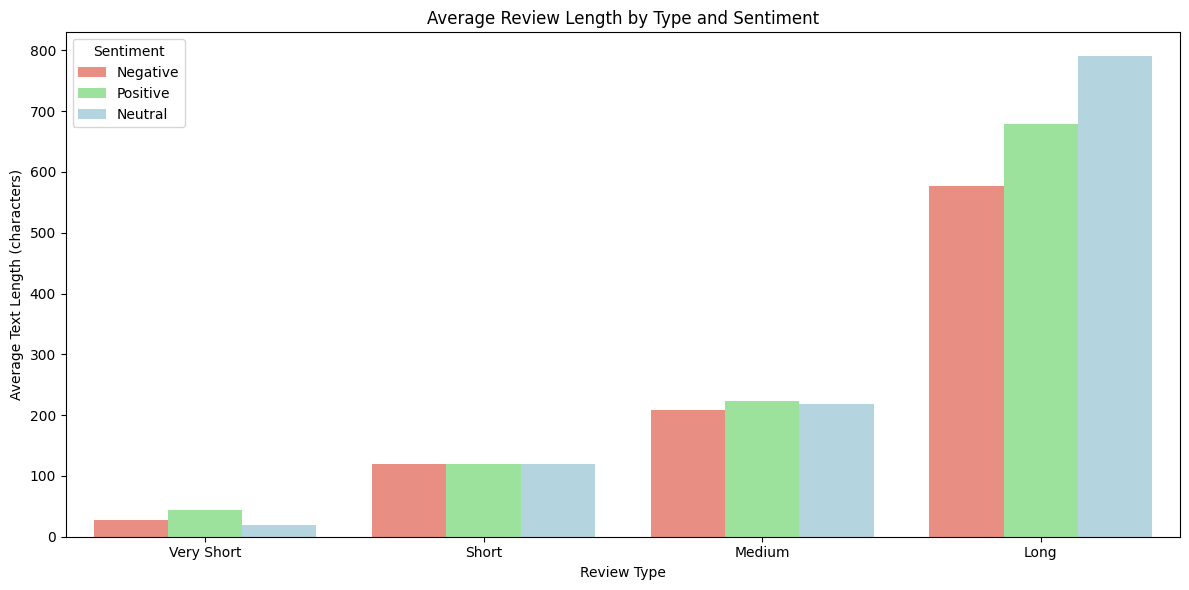

In [11]:
# Calculate text length for each review
df['text_length'] = df['reviewText'].apply(len)

# Define bins and labels for review length
bins = [0, 50, 150, 300, np.inf]
labels = ['Very Short', 'Short', 'Medium', 'Long']
df['review_type'] = pd.cut(df['text_length'], bins=bins, labels=labels)

# Ensure sentiment column exists
if 'sentiment' not in df.columns:
    df['sentiment'] = (df['overall'] > 3).astype(int)

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='review_type', y='text_length', hue='type',
           data=df, palette=['salmon', 'lightgreen', 'lightblue'],
           ci=None)  # No confidence intervals

plt.title('Average Review Length by Type and Sentiment')
plt.xlabel('Review Type')
plt.ylabel('Average Text Length (characters)')
plt.legend(title='Sentiment', labels=['Negative', 'Positive', 'Neutral'])
plt.tight_layout()
plt.show()

In [12]:
# Fill NaNs with empty string
df['reviewText'] = df['reviewText'].fillna('')

df['lower'] = df['reviewText'].str.lower()
df['lower'] = df['lower'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['lower'] = df['lower'].apply(lambda x: re.sub(r'\d+', '', x))
df['lower'] = [str(i).strip() for i in df['lower']]

# Define function to remove punctuation, numbers, stopwords, then tokenize, stem, and lemmatize in lower column
def preprocess_text(text):
    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing Numbers
    text = re.sub(r'\d+', '', text)

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in (stop_words)])

    # Tokenization
    text = word_tokenize(text)

    # Stemming
    stemmer = nltk.PorterStemmer()
    text = [stemmer.stem(y) for y in text]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(y) for y in text]

    return text

df['lower'] = df['lower'].apply(preprocess_text)
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type,text_length,review_type,sentiment,lower
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive,158,Medium,1,"[purchas, devic, work, advertis, never, much, ..."
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive,166,Medium,1,"[work, expect, sprung, higher, capac, think, m..."
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive,340,Long,1,"[think, work, greathad, diff, bran, gb, card, ..."
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive,290,Medium,1,"[bought, retail, packag, arriv, legit, orang, ..."
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive,282,Medium,1,"[mini, storag, doesnt, anyth, el, suppos, purc..."


In [13]:
# Perform Word Embedding using CountVectorizer
cv = CountVectorizer(max_features=5000)
X = cv.fit_transform(df['lower'].apply(lambda x: ' '.join(x))).toarray()
# Use the multi-class 'type' column instead of 'sentiment'
y = df['type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y, shuffle=True)

# Define a function to train and evaluate the model
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,
                                average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred))

    return accuracy, precision, recall, f1, auc_roc, y_pred

-------------------------
Logistic Regression Model
-------------------------
Accuracy: 0.9267548321464903
Precision: 0.5577107279693486
Recall: 0.5075770671276288
F1 Score: 0.5277217987285454
AUC-ROC: 0.6570167255768566
--------------------------------------------------
Classification Report of Logistic Regression Model
--------------------------------------------------
              precision    recall  f1-score   support

    negative       0.73      0.54      0.62        65
     neutral       0.00      0.00      0.00        28
    positive       0.94      0.98      0.96       890

    accuracy                           0.93       983
   macro avg       0.56      0.51      0.53       983
weighted avg       0.90      0.93      0.91       983

----------------------------------------
Confustion Matrix of Logistic Regression
----------------------------------------


<Figure size 800x600 with 0 Axes>

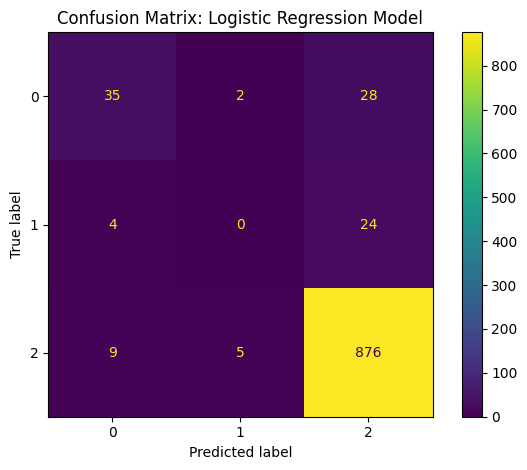

------------------------------------
ROC Curve: Logistic Regression Model
------------------------------------


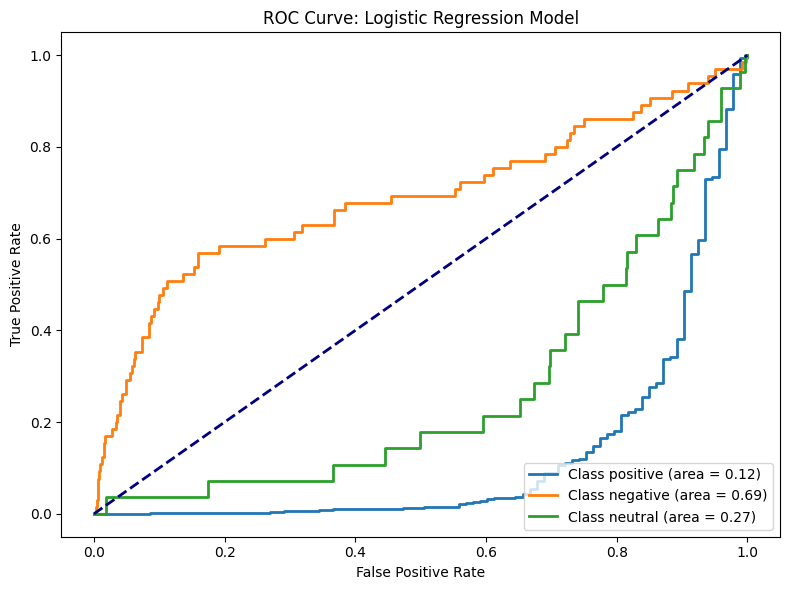

In [14]:
# Initialize Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Train and evaluate the model
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc_roc, y_pred = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('-------------------------')
print('Logistic Regression Model')
print('-------------------------')
print('Accuracy:', lr_accuracy)
print('Precision:', lr_precision)
print('Recall:', lr_recall)
print('F1 Score:', lr_f1)
print('AUC-ROC:', lr_auc_roc)

# Classification Report on Logistic Regression
print('--------------------------------------------------')
print('Classification Report of Logistic Regression Model')
print('--------------------------------------------------')
print(classification_report(y_test, y_pred))

# Compute and display the confusion matrix
print('----------------------------------------')
print('Confustion Matrix of Logistic Regression')
print('----------------------------------------')
# Use y_pred instead of y_pred_svm_smote for consistency
cm_multi_lr = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_lr)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model')
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC Curve
print('------------------------------------')
print('ROC Curve: Logistic Regression Model')
print('------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize the output labels for multi-class ROC curve, inferring classes
classes_ = y_test.unique() # Get unique classes from y_test
y_test_binarized = label_binarize(y_test, classes=classes_) # Use inferred classes
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(classes_): # Iterate through inferred classes
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression Model')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

-------------------------------------
Logistic Regression Model after SMOTE
-------------------------------------
Accuracy: 0.8676911544227887
Precision: 0.8725563503715098
Recall: 0.8676756697547637
F1 Score: 0.8679231528820012
AUC-ROC: 0.9007646608453838
-----------------------------------------------------------
Logistic Regression Model after SMOTE Classification Report
-----------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83       889
     neutral       0.79      0.91      0.85       889
    positive       0.95      0.91      0.93       890

    accuracy                           0.87      2668
   macro avg       0.87      0.87      0.87      2668
weighted avg       0.87      0.87      0.87      2668

-------------------------------------------------------
Confusion Matrix: Logistic Regression Model after SMOTE
-------------------------------------------------------


<Figure size 800x600 with 0 Axes>

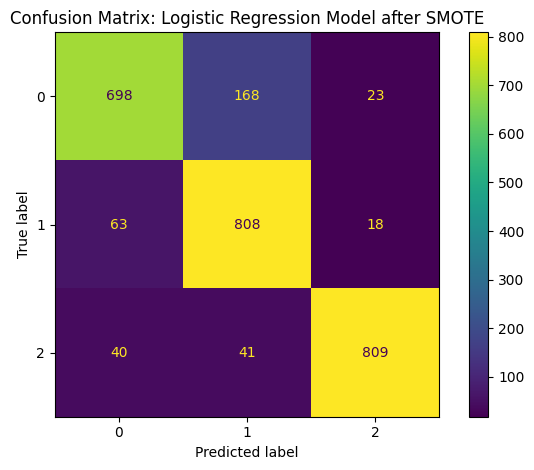

------------------------------------------------
ROC Curve: Logistic Regression Model after SMOTE
------------------------------------------------


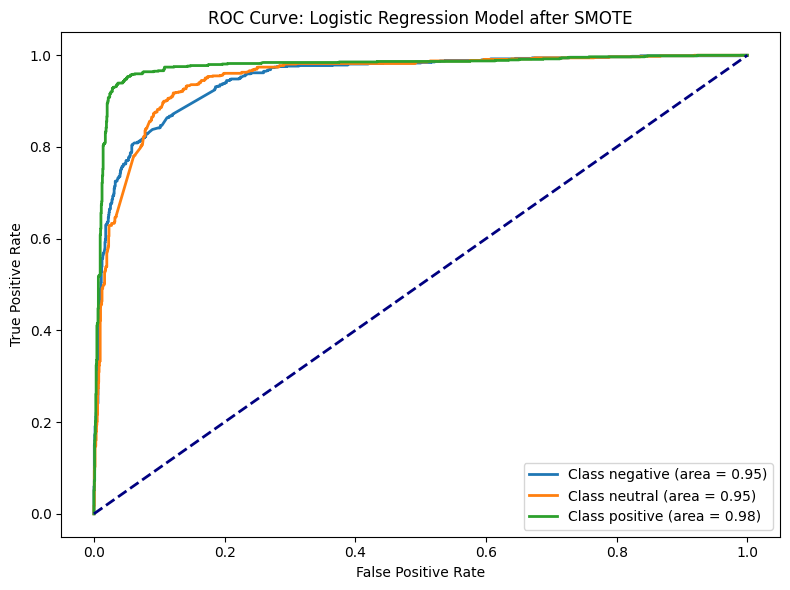

In [15]:
# Class count
count_class_0, count_class_1, count_class_2 = df['type'].value_counts()

# Divide by class
df_class_0 = df[df['type'] == 'positive']
df_class_1 = df[df['type'] == 'neutral']
df_class_2 = df[df['type'] == 'negative']

# Random oversampling
df_class_2_over = df_class_2.sample(count_class_0,
                                    replace=True)
df_test_over = pd.concat([df_class_0, df_class_1,
                          df_class_2_over], axis=0)

# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_smote,
                                                    shuffle=True)
lr = LogisticRegression(max_iter=1000)
lr_accuracy_smote, lr_precision_smote, lr_recall_smote, lr_f1_smote, lr_auc_roc_smote, y_pred_smote = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

print('-------------------------------------')
print('Logistic Regression Model after SMOTE')
print('-------------------------------------')
print('Accuracy:', lr_accuracy_smote)
print('Precision:', lr_precision_smote)
print('Recall:', lr_recall_smote)
print('F1 Score:', lr_f1_smote)
print('AUC-ROC:', lr_auc_roc_smote)

print('-----------------------------------------------------------')
print('Logistic Regression Model after SMOTE Classification Report')
print('-----------------------------------------------------------')
print(classification_report(y_test, y_pred_smote))

# Compute and display the confusion matrix
print('-------------------------------------------------------')
print('Confusion Matrix: Logistic Regression Model after SMOTE')
print('-------------------------------------------------------')
cm_multi_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_smote)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model after SMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC Curve after SMOTE
print('------------------------------------------------')
print('ROC Curve: Logistic Regression Model after SMOTE')
print('------------------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize the output labels for multi-class ROC curve
classes_ = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Define labels_order based on the unique classes in y_test
labels_order = classes_

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(labels_order):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i],
                            lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'Class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression Model after SMOTE')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

---------------------------------------
Logistic Regression Model after SMOTENC
---------------------------------------
Accuracy: 0.8676911544227887
Precision: 0.8728224811937353
Recall: 0.8676760910504164
F1 Score: 0.8679643711055465
AUC-ROC: 0.9007649241847687
-------------------------------------------------------------
Logistic Regression Model after SMOTENC Classification Report
-------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83       889
     neutral       0.79      0.91      0.85       889
    positive       0.95      0.91      0.93       890

    accuracy                           0.87      2668
   macro avg       0.87      0.87      0.87      2668
weighted avg       0.87      0.87      0.87      2668

------------------------------------------------------
Confustion Matrix of Logistic Regression after SMOTENC
------------------------------------------------------


<Figure size 800x600 with 0 Axes>

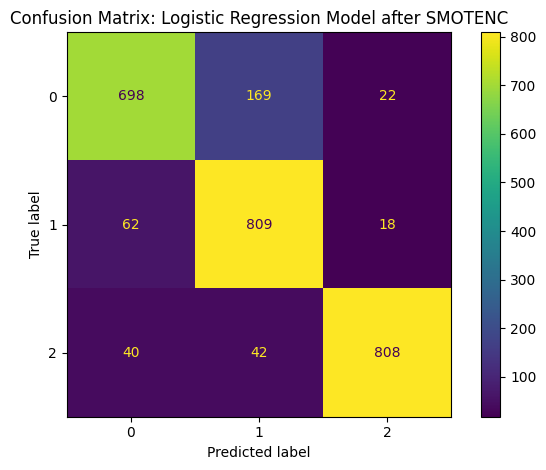

--------------------------------------------------
ROC Curve: Logistic Regression Model after SMOTENC
--------------------------------------------------


Text(0.5, 1.0, 'ROC Curve: Logistic Regression Model after SMOTENC')

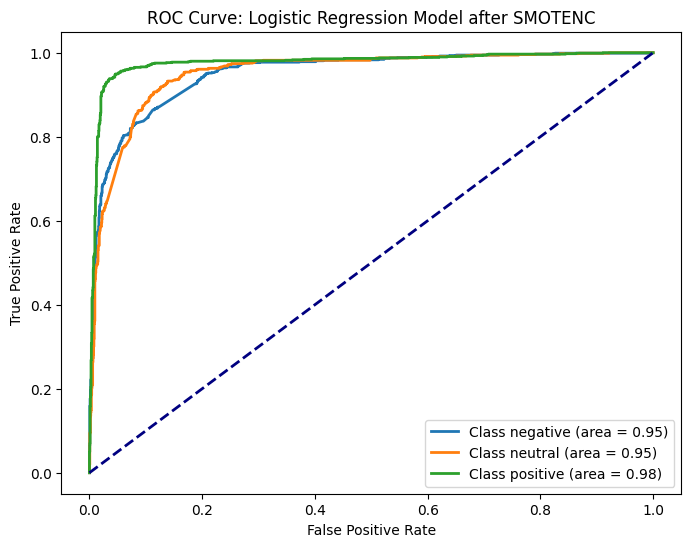

In [16]:
# Identify categorical features
categorical_features = [i for i, col in enumerate(df_test_over.columns) if df_test_over[col].dtype == 'object']


smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_smote_nc, y_smote_nc = smote_nc.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote_nc, y_smote_nc,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_smote_nc,
                                                    shuffle=True)

lr = LogisticRegression(max_iter=1000)
lr_accuracy_smotenc, lr_precision_smotenc, lr_recall_smotenc, lr_f1_smotenc, lr_auc_roc_smotenc, y_pred_smotenc = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

print('---------------------------------------')
print('Logistic Regression Model after SMOTENC')
print('---------------------------------------')
print('Accuracy:', lr_accuracy_smotenc)
print('Precision:', lr_precision_smotenc)
print('Recall:', lr_recall_smotenc)
print('F1 Score:', lr_f1_smotenc)
print('AUC-ROC:', lr_auc_roc_smotenc)

# Classification Report after SMOTENC
print('-------------------------------------------------------------')
print('Logistic Regression Model after SMOTENC Classification Report')
print('-------------------------------------------------------------')
print(classification_report(y_test, y_pred_smotenc))

# Compute and display the confusion matrix
print('------------------------------------------------------')
print('Confustion Matrix of Logistic Regression after SMOTENC')
print('------------------------------------------------------')
cm_multi_smotenc = confusion_matrix(y_test, y_pred_smotenc)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_smotenc)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model after SMOTENC')
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC Curve after SMOTENC
print('--------------------------------------------------')
print('ROC Curve: Logistic Regression Model after SMOTENC')
print('--------------------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize the output labels for multi-class ROC curve
classes_ = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(labels_order):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve: Logistic Regression Model after SMOTENC')

--------------------------------------
Logistic Regression Model after ADASYN
--------------------------------------
Accuracy: 0.8552729992520568
Precision: 0.862487449075533
Recall: 0.855769158798653
F1 Score: 0.8555786045235715
AUC-ROC: 0.8917419631713662
------------------------------------------------------------
Logistic Regression Model after ADASYN Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.87      0.76      0.81       900
     neutral       0.77      0.91      0.83       885
    positive       0.95      0.90      0.92       889

    accuracy                           0.86      2674
   macro avg       0.86      0.86      0.86      2674
weighted avg       0.86      0.86      0.86      2674

-----------------------------------------------------
Confustion Matrix of Logistic Regression after ADASYN
-----------------------------------------------------


<Figure size 800x600 with 0 Axes>

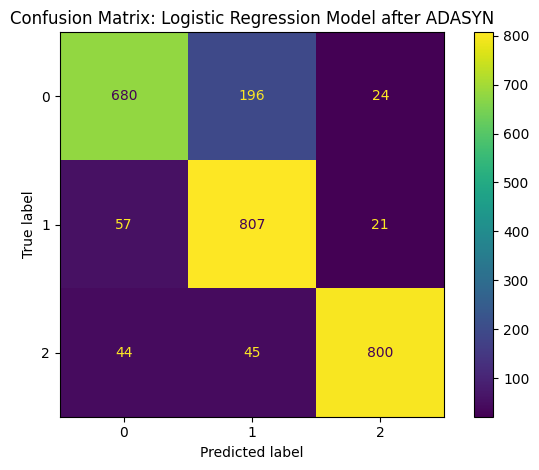

-------------------------------------------------
ROC Curve: Logistic Regression Model after ADASYN
-------------------------------------------------


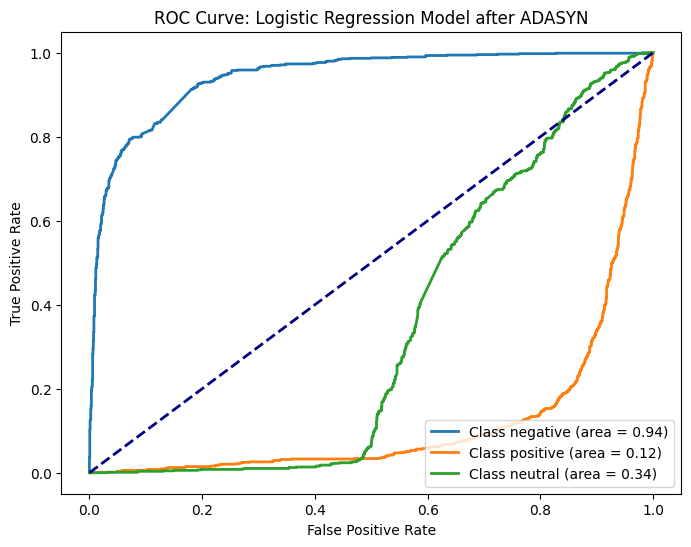

In [17]:
# Assuming X and y are your features and target variable
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Now X_adasyn and y_adasyn contain the resampled data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_adasyn,
                                                    shuffle=True)

lr = LogisticRegression(max_iter=1000)
lr_accuracy_adasyn, lr_precision_adasyn, lr_recall_adasyn, lr_f1_adasyn, lr_auc_roc_adasyn, y_pred_adasyn = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

print('--------------------------------------')
print('Logistic Regression Model after ADASYN')
print('--------------------------------------')
print('Accuracy:', lr_accuracy_adasyn)
print('Precision:', lr_precision_adasyn)
print('Recall:', lr_recall_adasyn)
print('F1 Score:', lr_f1_adasyn)
print('AUC-ROC:', lr_auc_roc_adasyn)

# Classification Report after ADASYN
print('------------------------------------------------------------')
print('Logistic Regression Model after ADASYN Classification Report')
print('------------------------------------------------------------')
print(classification_report(y_test, y_pred_adasyn))

# Compute and display the confusion matrix
print('-----------------------------------------------------')
print('Confustion Matrix of Logistic Regression after ADASYN')
print('-----------------------------------------------------')
cm_multi_adasyn = confusion_matrix(y_test, y_pred_adasyn)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_adasyn)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model after ADASYN')
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC Curve
print('-------------------------------------------------')
print('ROC Curve: Logistic Regression Model after ADASYN')
print('-------------------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize the output labels for multi-class ROC curve
classes_ = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression Model after ADASYN')
plt.legend(loc='lower right')
plt.show()

-----------------------------------------------
Logistic Regression Model after BorderlineSMOTE
-----------------------------------------------
Accuracy: 0.9441529235382309
Precision: 0.94457120950227
Recall: 0.9441568399455686
F1 Score: 0.944105061697455
AUC-ROC: 0.9581173699944195
---------------------------------------------------------------------
Logistic Regression Model after BorderlineSMOTE Classification Report
---------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.95      0.93      0.94       889
     neutral       0.93      0.97      0.95       889
    positive       0.96      0.93      0.95       890

    accuracy                           0.94      2668
   macro avg       0.94      0.94      0.94      2668
weighted avg       0.94      0.94      0.94      2668

--------------------------------------------------------------
Confustion Matrix of Logistic Regression after BorderlineSMOTE

<Figure size 800x600 with 0 Axes>

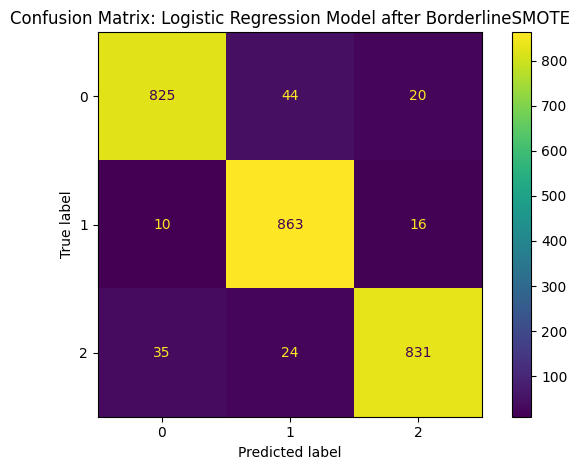

----------------------------------------------------------
ROC Curve: Logistic Regression Model after BorderlineSMOTE
----------------------------------------------------------


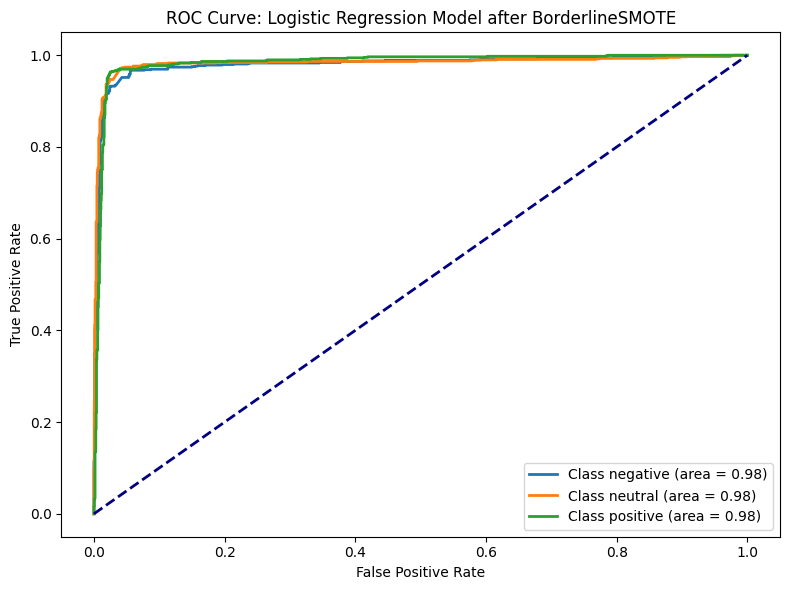

In [18]:
# Assuming X and y are your features and target variable
borderline_smote = BorderlineSMOTE(random_state=42)
X_borderline_smote, y_borderline_smote = borderline_smote.fit_resample(X, y)

# Now X_borderline_smote and y_borderline_smote contain the resampled data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_borderline_smote, y_borderline_smote,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_borderline_smote,
                                                    shuffle=True)

lr = LogisticRegression(max_iter=1000)
lr_accuracy_borderline_smote, lr_precision_borderline_smote, lr_recall_borderline_smote, lr_f1_borderline_smote, lr_auc_roc_borderline_smote, y_pred_borderline_smote = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

print('-----------------------------------------------')
print('Logistic Regression Model after BorderlineSMOTE')
print('-----------------------------------------------')
print('Accuracy:', lr_accuracy_borderline_smote)
print('Precision:', lr_precision_borderline_smote)
print('Recall:', lr_recall_borderline_smote)
print('F1 Score:', lr_f1_borderline_smote)
print('AUC-ROC:', lr_auc_roc_borderline_smote)

# Classification Report after BorderlineSMOTE
print('---------------------------------------------------------------------')
print('Logistic Regression Model after BorderlineSMOTE Classification Report')
print('---------------------------------------------------------------------')
print(classification_report(y_test, y_pred_borderline_smote))

# Compute and display the confusion matrix
print('--------------------------------------------------------------')
print('Confustion Matrix of Logistic Regression after BorderlineSMOTE')
print('--------------------------------------------------------------')
cm_multi_borderline_smote = confusion_matrix(y_test, y_pred_borderline_smote)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_borderline_smote)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model after BorderlineSMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC Curve
print('----------------------------------------------------------')
print('ROC Curve: Logistic Regression Model after BorderlineSMOTE')
print('----------------------------------------------------------')
plt.figure(figsize=(8, 6))
# Binarize the output labels for multi-class ROC curve
classes_ = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(labels_order):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve: Logistic Regression Model after BorderlineSMOTE')
plt.tight_layout()
plt.show()

----------------------------------------
Logistic Regression Model after SVMSMOTE
----------------------------------------
Accuracy: 0.9292983395822174
Precision: 0.9211951563609825
Recall: 0.9272042949064319
F1 Score: 0.9240582392655593
AUC-ROC: 0.9460213982497904
--------------------------------------------------------------
Logistic Regression Model after SVMSMOTE Classification Report
--------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.90      0.91      0.90       518
     neutral       0.90      0.93      0.92       459
    positive       0.96      0.94      0.95       890

    accuracy                           0.93      1867
   macro avg       0.92      0.93      0.92      1867
weighted avg       0.93      0.93      0.93      1867

-------------------------------------------------------
Confustion Matrix of Logistic Regression after SVMSMOTE
----------------------------------------------------

<Figure size 800x600 with 0 Axes>

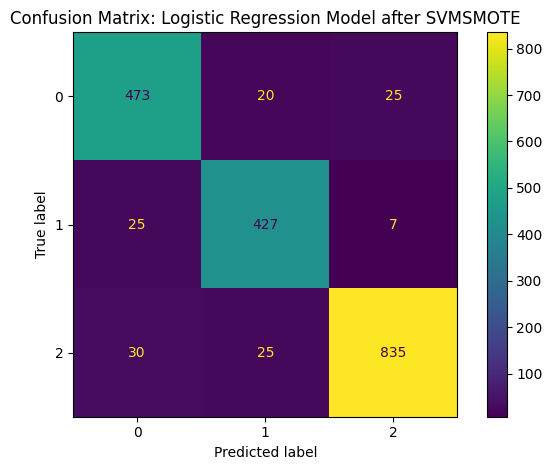

---------------------------------------------------
ROC Curve: Logistic Regression Model after SVMSMOTE
---------------------------------------------------


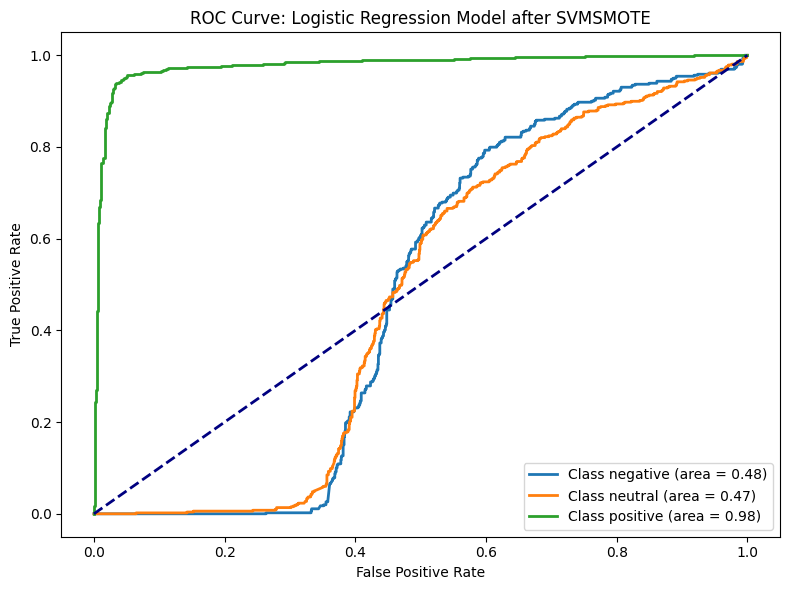

In [19]:
# Assuming X and y are your features and target variable
svm_smote = SVMSMOTE(random_state=42)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X, y)

# Now X_svm_smote and y_svm_smote contain the resampled data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_svm_smote, y_svm_smote,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_svm_smote,
                                                    shuffle=True)

lr = LogisticRegression(max_iter=1000)
lr_accuracy_svm_smote, lr_precision_svm_smote, lr_recall_svm_smote, lr_f1_svm_smote, lr_auc_roc_svm_smote, y_pred_svm_smote = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

print('----------------------------------------')
print('Logistic Regression Model after SVMSMOTE')
print('----------------------------------------')
print('Accuracy:', lr_accuracy_svm_smote)
print('Precision:', lr_precision_svm_smote)
print('Recall:', lr_recall_svm_smote)
print('F1 Score:', lr_f1_svm_smote)
print('AUC-ROC:', lr_auc_roc_svm_smote)

# Classification Report on SVM SMOTE
print('--------------------------------------------------------------')
print('Logistic Regression Model after SVMSMOTE Classification Report')
print('--------------------------------------------------------------')
print(classification_report(y_test, y_pred_svm_smote))

# Compute and display the confusion matrix
print('-------------------------------------------------------')
print('Confustion Matrix of Logistic Regression after SVMSMOTE')
print('-------------------------------------------------------')
cm_multi_svm_smote = confusion_matrix(y_test, y_pred_svm_smote)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_svm_smote)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model after SVMSMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC Curve
print('---------------------------------------------------')
print('ROC Curve: Logistic Regression Model after SVMSMOTE')
print('---------------------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize the output labels for multi-class ROC curve
classes_ = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(labels_order):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve: Logistic Regression Model after SVMSMOTE')
plt.tight_layout()
plt.show()

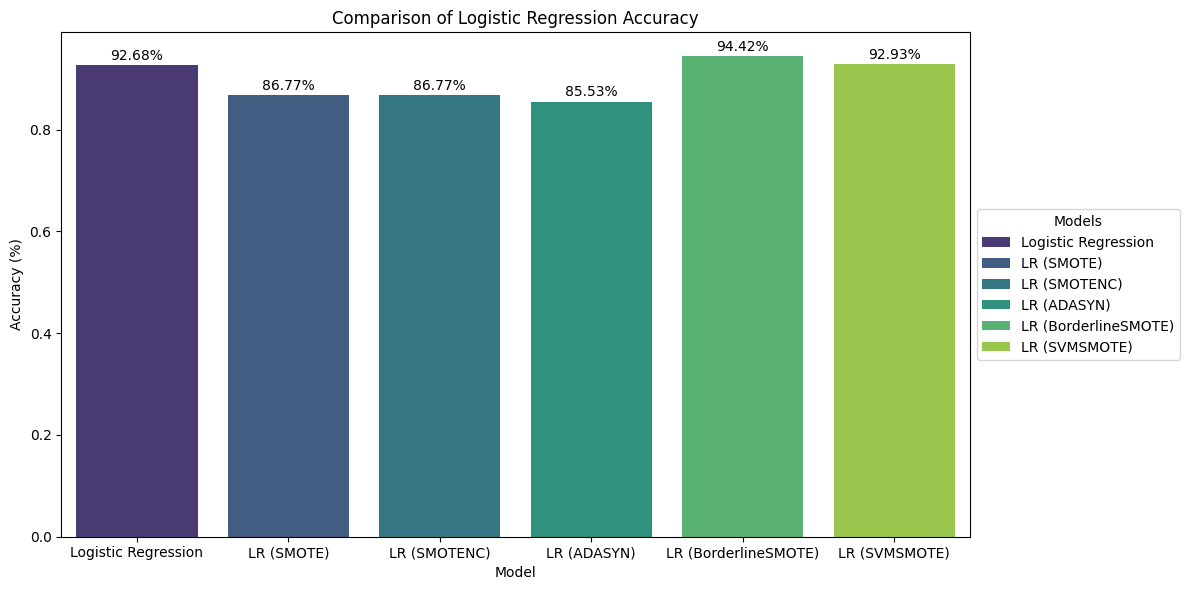

In [20]:
models = ['Logistic Regression', 'LR (SMOTE)', 'LR (SMOTENC)',
          'LR (ADASYN)', 'LR (BorderlineSMOTE)', 'LR (SVMSMOTE)']
accuracy_scores = [lr_accuracy, lr_accuracy_smote,
                   lr_accuracy_smotenc, lr_accuracy_adasyn,
                   lr_accuracy_borderline_smote, lr_accuracy_svm_smote]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=models, y=accuracy_scores, palette="viridis")
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Logistic Regression Accuracy')
plt.xticks(fontsize=10)

for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center')

handles = ax.patches
labels = models

# Create a new legend outside the plot
plt.legend(handles, labels, title='Models',
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Multinomial Naive Bayes Model
-----------------------------
Accuracy: 0.8784145688269952
Precision: 0.8758207461479537
Recall: 0.854260778891755
F1 Score: 0.8633956025376045
AUC-ROC: 0.8941009672052473
------------------------------------------------------
Classification Report of Multinomial Naive Bayes Model
------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.88      0.82      0.85       518
     neutral       0.87      0.78      0.82       459
    positive       0.88      0.96      0.92       890

    accuracy                           0.88      1867
   macro avg       0.88      0.85      0.86      1867
weighted avg       0.88      0.88      0.88      1867

--------------------------------------------------
Confusion Matrix for Multinomial Naive Bayes Model
--------------------------------------------------


<Figure size 800x600 with 0 Axes>

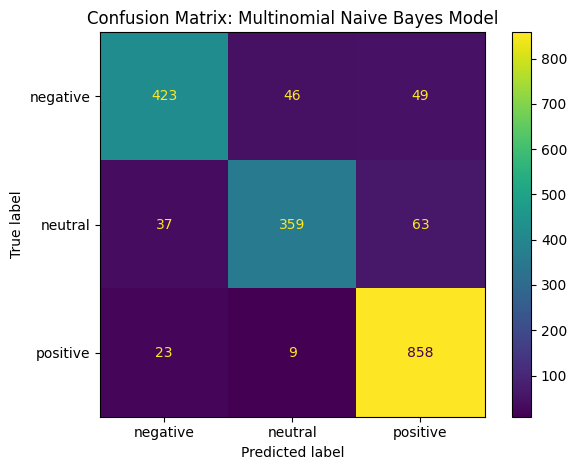

-------------------------------------------
ROC Curve for Multinomial Naive Bayes Model
-------------------------------------------


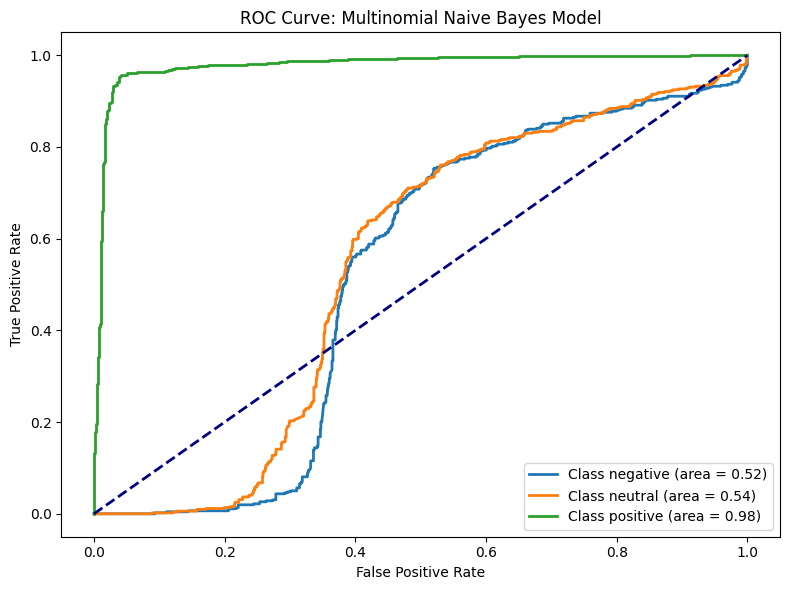

In [21]:
# Initialize Multinomial Naive Bayes model
nb = MultinomialNB()

# Train and evaluate the model
nb_accuracy, nb_precision, nb_recall, nb_f1, nb_auc_roc, _ = train_evaluate_model(nb, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Multinomial Naive Bayes Model')
print('-----------------------------')
print('Accuracy:', nb_accuracy)
print('Precision:', nb_precision)
print('Recall:', nb_recall)
print('F1 Score:', nb_f1)
print('AUC-ROC:', nb_auc_roc)

# Classification Report
print('------------------------------------------------------')
print('Classification Report of Multinomial Naive Bayes Model')
print('------------------------------------------------------')
print(classification_report(y_test, nb.predict(X_test)))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, nb.predict(X_test))
print('--------------------------------------------------')
print('Confusion Matrix for Multinomial Naive Bayes Model')
print('--------------------------------------------------')
# Display the confusion matrix using labels
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Multinomial Naive Bayes Model')
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC Curve
print('-------------------------------------------')
print('ROC Curve for Multinomial Naive Bayes Model')
print('-------------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize
classes_ = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(labels_order):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], nb.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve: Multinomial Naive Bayes Model')
plt.tight_layout()
plt.show()

------------------------------
Random Forest Classifier Model
------------------------------
Accuracy: 0.9587573647562935
Precision: 0.959586083378436
Recall: 0.9527068786597317
F1 Score: 0.9559159775615559
AUC-ROC: 0.9652248145128288
-------------------------------------------------------
Classification Report of Random Forest Classifier Model
-------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.93      0.94      0.93       518
     neutral       0.99      0.94      0.96       459
    positive       0.96      0.98      0.97       890

    accuracy                           0.96      1867
   macro avg       0.96      0.95      0.96      1867
weighted avg       0.96      0.96      0.96      1867

---------------------------------------------------
Confusion Matrix for Random Forest Classifier Model
---------------------------------------------------


<Figure size 800x600 with 0 Axes>

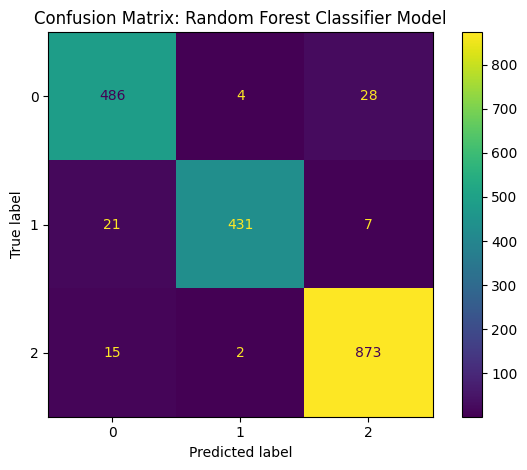

--------------------------------------------
ROC Curve for Random Forest Classifier Model
--------------------------------------------


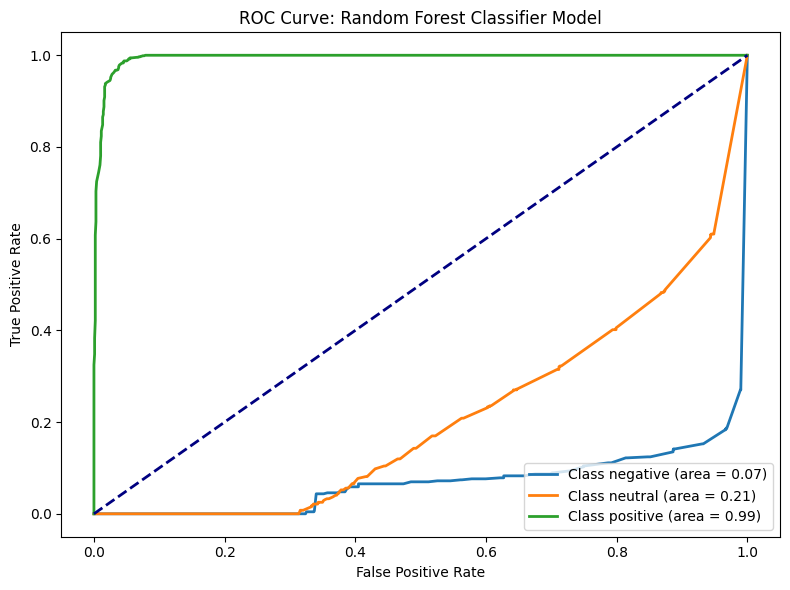

In [22]:
# Initialize Random Forest Classifier model
rf = RandomForestClassifier()

# Train and evaluate the model
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc_roc, _ = train_evaluate_model(rf, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('------------------------------')
print('Random Forest Classifier Model')
print('------------------------------')
print('Accuracy:', rf_accuracy)
print('Precision:', rf_precision)
print('Recall:', rf_recall)
print('F1 Score:', rf_f1)
print('AUC-ROC:', rf_auc_roc)

# Classification Report
print('-------------------------------------------------------')
print('Classification Report of Random Forest Classifier Model')
print('-------------------------------------------------------')
print(classification_report(y_test, rf.predict(X_test)))

# Confusion Matrix
print('---------------------------------------------------')
print('Confusion Matrix for Random Forest Classifier Model')
print('---------------------------------------------------')
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Random Forest Classifier Model')
plt.grid(False)
plt.tight_layout()
plt.show()

# ROC Curve
print('--------------------------------------------')
print('ROC Curve for Random Forest Classifier Model')
print('--------------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize
classes_ = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC
for i, class_label in enumerate(labels_order):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve: Random Forest Classifier Model')
plt.tight_layout()
plt.show()

Linear Support Vector Classifier Model
--------------------------------------
Accuracy: 0.9266202463845742
Precision: 0.9181213889501084
Recall: 0.9264075109635805
F1 Score: 0.9219447664365285
AUC-ROC: 0.9451412134507068
---------------------------------------------------------------
Classification Report of Linear Support Vector Classifier Model
---------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.88      0.92      0.90       518
     neutral       0.91      0.93      0.92       459
    positive       0.97      0.93      0.95       890

    accuracy                           0.93      1867
   macro avg       0.92      0.93      0.92      1867
weighted avg       0.93      0.93      0.93      1867

-----------------------------------------------------------
Confusion Matrix for Linear Support Vector Classifier Model
-----------------------------------------------------------


<Figure size 800x600 with 0 Axes>

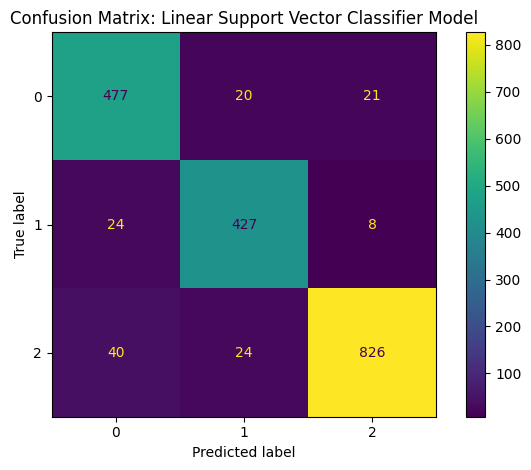

----------------------------------------------------
ROC Curve for Linear Support Vector Classifier Model
----------------------------------------------------


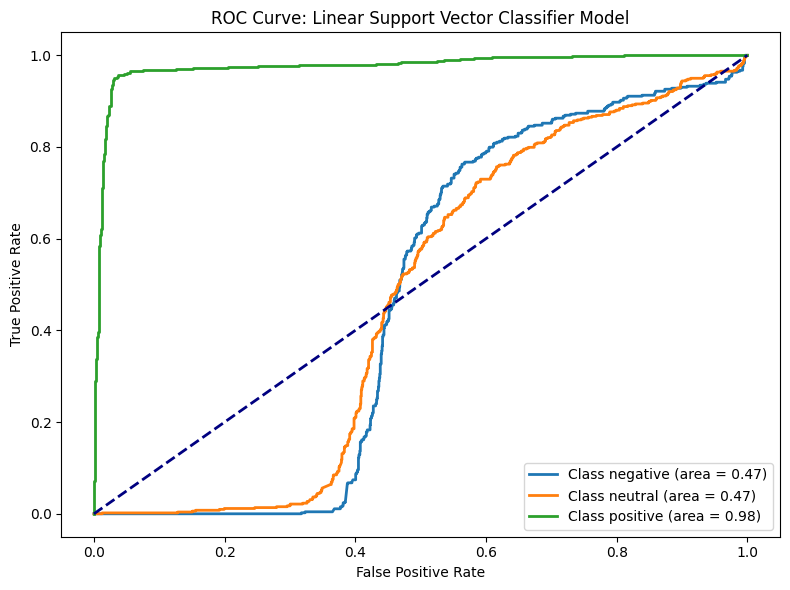

In [23]:
# Initialize Linear Support Vector Classifier model
svc = LinearSVC()

# Train and evaluate the model
svc_accuracy, svc_precision, svc_recall, svc_f1, svc_auc_roc, svc_y_pred = train_evaluate_model(svc, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Linear Support Vector Classifier Model')
print('--------------------------------------')
print('Accuracy:', svc_accuracy)
print('Precision:', svc_precision)
print('Recall:', svc_recall)
print('F1 Score:', svc_f1)
print('AUC-ROC:', svc_auc_roc)

# Classification Report
print('---------------------------------------------------------------')
print('Classification Report of Linear Support Vector Classifier Model')
print('---------------------------------------------------------------')
print(classification_report(y_test, svc.predict(X_test)))

# Confusion Matrix
print('-----------------------------------------------------------')
print('Confusion Matrix for Linear Support Vector Classifier Model')
print('-----------------------------------------------------------')
cm_svc = confusion_matrix(y_test, svc.predict(X_test))
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Linear Support Vector Classifier Model')
plt.grid(False)
plt.tight_layout()
plt.show()

# ROC Curve
print('----------------------------------------------------')
print('ROC Curve for Linear Support Vector Classifier Model')
print('----------------------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize
classes_ = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Plot ROC Curve as one graph
for i, class_label in enumerate(labels_order):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], svc.decision_function(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve: Linear Support Vector Classifier Model')
plt.tight_layout()
plt.show()

In [24]:
# Class count
count_class_0, count_class_1, count_class_2 = df['type'].value_counts()

# Divide by class
df_class_0 = df[df['type'] == 'positive']
df_class_1 = df[df['type'] == 'neutral']
df_class_2 = df[df['type'] == 'negative']

# Random oversampling
df_class_2_over = df_class_2.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1, df_class_2_over], axis=0)

# Assuming 'lower' column contains the preprocessed text data
X = cv.fit_transform(df_test_over['lower'].apply(lambda x: ' '.join(x))).toarray()
y = df_test_over['type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y, shuffle=True)

X_train_lstm = np.array(X_train)
X_test_lstm = np.array(X_test)
y_train_lstm = np.array(y_train)
y_test_lstm = np.array(y_test)
# Reshape the input data to be 3D [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0],
                                    X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0],
                                  X_test_lstm.shape[1], 1)

# Encode string labels into numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the number of classes
num_classes = len(np.unique(y_train_encoded))
# Convert the labels to categorical format
y_train_lstm = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_lstm = to_categorical(y_test_encoded, num_classes=num_classes)


# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5000, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5000, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,483 (501.89 KB)

 Trainable params: 128,483 (501.89 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10,
                    batch_size=64, validation_data=(X_test_lstm,
                                                    y_test_lstm))
# Evaluate the model
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate Metrics for LSTM using MSE, RMSE, MAE, and R2 Score
lstm_mse = np.mean((y_test_lstm - model.predict(X_test_lstm))**2)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = np.mean(np.abs(y_test_lstm - model.predict(X_test_lstm)))
lstm_r2 = 1 - (np.sum((y_test_lstm - model.predict(X_test_lstm))**2) / np.sum((y_test_lstm - np.mean(y_test_lstm))**2))
print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM R2 Score: {lstm_r2:.4f}")

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 467ms/step - accuracy: 0.4855 - loss: 0.8661 - val_accuracy: 0.4920 - val_loss: 0.7686
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 84s 511ms/step - accuracy: 0.4737 - loss: 0.7859 - val_accuracy: 0.4920 - val_loss: 0.7646
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 515ms/step - accuracy: 0.4800 - loss: 0.7827 - val_accuracy: 0.4920 - val_loss: 0.7649
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 516ms/step - accuracy: 0.5033 - loss: 0.7682 - val_accuracy: 0.4920 - val_loss: 0.7649
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 517ms/step - accuracy: 0.4775 - loss: 0.7844 - val_accuracy: 0.4920 - val_loss: 0.7668
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 516ms/step - accuracy: 0.4920 - loss: 0.7648 - val_accuracy: 0.4920 - val_loss: 0.7644
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 470ms/step - accuracy: 0.4855 - loss: 0.7772 - val_accuracy: 0.4920 - val_loss: 0.7645
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 472ms/step - accuracy: 0.4947 - loss: 0

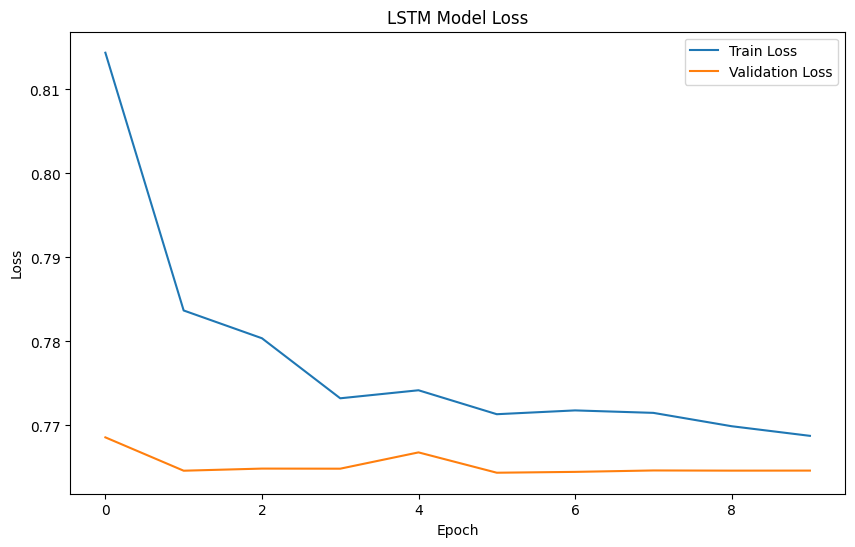

In [26]:
# Plot LSTM validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [27]:
# Print classification report of LSTM model
y_pred_lstm = np.argmax(model.predict(X_test_lstm), axis=-1)
y_test_lstm_labels = np.argmax(y_test_lstm, axis=-1)
print(classification_report(y_test_lstm_labels, y_pred_lstm))

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       889
           1       0.00      0.00      0.00        29
           2       0.49      1.00      0.66       889

    accuracy                           0.49      1807
   macro avg       0.16      0.33      0.22      1807
weighted avg       0.24      0.49      0.32      1807



<Figure size 800x600 with 0 Axes>

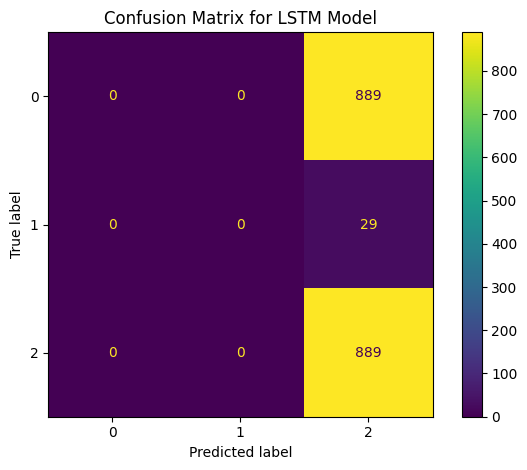

In [28]:
# Confusion Matrix LSTM
cm = confusion_matrix(y_test_lstm_labels, y_pred_lstm)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix for LSTM Model')
plt.tight_layout()
plt.grid(False)
plt.show()

In [29]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled, shuffle=True)

# Convert to numpy arrays and reshape for LSTM
X_train_lstm = np.array(X_train)
X_test_lstm = np.array(X_test)
y_train_lstm = np.array(y_train)
y_test_lstm = np.array(y_test)

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Encode labels and convert to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(np.unique(y_train_encoded))
y_train_lstm = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_lstm = to_categorical(y_test_encoded, num_classes=num_classes)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 5000, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 5000, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,483 (501.89 KB)

 Trainable params: 128,483 (501.89 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10,
                    batch_size=64, validation_data=(X_test_lstm,
                                                    y_test_lstm))
# Evaluate the model
lstm_loss_ros, lstm_accuracy_ros = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate Metrics for LSTM using MSE, RMSE, MAE, and R2 Score
lstm_mse = np.mean((y_test_lstm - model.predict(X_test_lstm))**2)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = np.mean(np.abs(y_test_lstm - model.predict(X_test_lstm)))
lstm_r2 = 1 - (np.sum((y_test_lstm - model.predict(X_test_lstm))**2) / np.sum((y_test_lstm - np.mean(y_test_lstm))**2))
print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM R2 Score: {lstm_r2:.4f}")

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 472ms/step - accuracy: 0.3403 - loss: 1.0990 - val_accuracy: 0.3430 - val_loss: 1.0962
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 85s 489ms/step - accuracy: 0.3435 - loss: 1.1056 - val_accuracy: 0.3302 - val_loss: 1.0992
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 484ms/step - accuracy: 0.3232 - loss: 1.0991 - val_accuracy: 0.3388 - val_loss: 1.0985
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 484ms/step - accuracy: 0.3327 - loss: 1.0986 - val_accuracy: 0.3332 - val_loss: 1.0981
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - accuracy: 0.3270 - loss: 1.0988 - val_accuracy: 0.3448 - val_loss: 1.0978
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 482ms/step - accuracy: 0.3392 - loss: 1.0982 - val_accuracy: 0.3355 - val_loss: 1.0967
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 484ms/step - accuracy: 0.3371 - loss: 1.0974 - val_accuracy: 0.3388 - val_loss: 1.0943
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 485ms/step - accuracy: 0.3307 - loss: 1

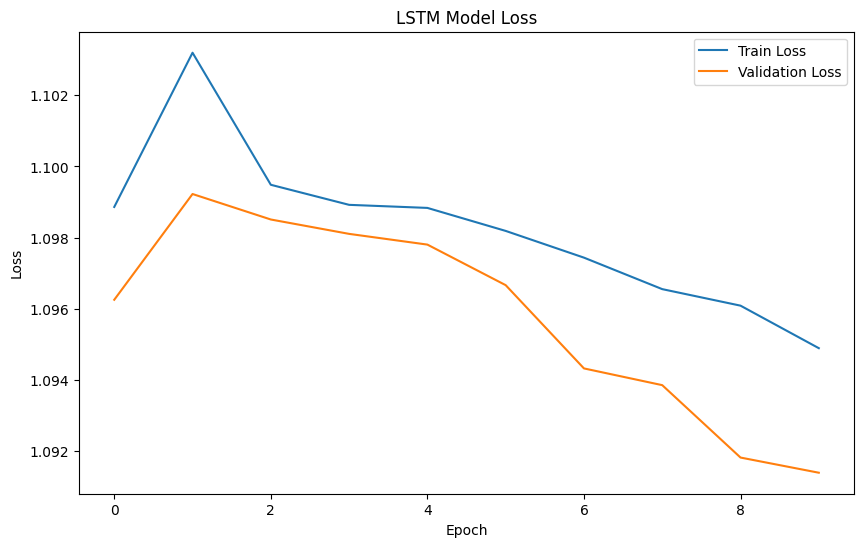

In [31]:
# Plot LSTM validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [32]:
# Print classification report of LSTM model
y_pred_lstm = np.argmax(model.predict(X_test_lstm), axis=-1)
y_test_lstm_labels = np.argmax(y_test_lstm, axis=-1)
print(classification_report(y_test_lstm_labels, y_pred_lstm))

84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step
              precision    recall  f1-score   support

           0       0.50      0.06      0.10       889
           1       0.34      0.98      0.50       889
           2       0.33      0.00      0.00       890

    accuracy                           0.34      2668
   macro avg       0.39      0.34      0.20      2668
weighted avg       0.39      0.34      0.20      2668



<Figure size 800x600 with 0 Axes>

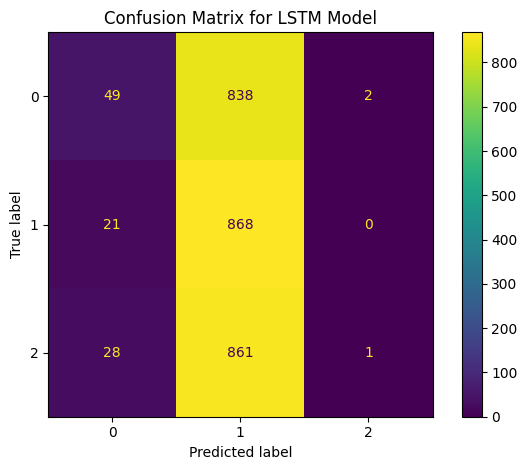

In [33]:
# Confusion Matrix LSTM
cm = confusion_matrix(y_test_lstm_labels, y_pred_lstm)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix for LSTM Model')
plt.tight_layout()
plt.grid(False)
plt.show()

In [34]:
X_train_gru = np.array(X_train)
X_test_gru = np.array(X_test)
y_train_gru = np.array(y_train)
y_test_gru = np.array(y_test)

# Reshape the input data
X_train_gru = X_train_gru.reshape(X_train_gru.shape[0],
                                  X_train_gru.shape[1], 1)
X_test_gru = X_test_gru.reshape(X_test_gru.shape[0],
                                X_test_gru.shape[1], 1)

# Encode string in categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the num_classes
num_classes = len(np.unique(y_train_encoded))
# Convert the labels to categorical format
y_train_gru = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_gru = to_categorical(y_test_encoded, num_classes=num_classes)

# Define GRU model architecture
gru_model = Sequential()
gru_model.add(GRU(128, input_shape=(X_train_gru.shape[1], 1),
                  return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(32, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(num_classes, activation='softmax'))

gru_model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5000, 128)      │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 5000, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,059 (379.14 KB)

 Trainable params: 97,059 (379.14 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
gru_history = gru_model.fit(X_train_gru, y_train_gru, epochs=10,
                        batch_size=64,
                        validation_data=(X_test_gru, y_test_gru))

# Evaluate the model
gru_loss, gru_accuracy = gru_model.evaluate(X_test_gru, y_test_gru, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluation Metrics
gru_mse = np.mean((y_test_gru - gru_model.predict(X_test_gru))**2)
gru_rmse = np.sqrt(gru_mse)
gru_mae = np.mean(np.abs(y_test_gru - gru_model.predict(X_test_gru)))
gru_r2 = 1 - (np.sum((y_test_gru - gru_model.predict(X_test_gru))**2) / np.sum((y_test_gru - np.mean(y_test_gru))**2))

print(f"GRU Model")
print("===========")
print(f"GRU MSE: {gru_mse:.4f}")
print(f"GRU RMSE: {gru_rmse:.4f}")
print(f"GRU MAE: {gru_mae:.4f}")
print(f"GRU R2 Score: {gru_r2:.4f}")

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 79s 458ms/step - accuracy: 0.3320 - loss: 1.1002 - val_accuracy: 0.3381 - val_loss: 1.0988
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 85s 475ms/step - accuracy: 0.3376 - loss: 1.1007 - val_accuracy: 0.3456 - val_loss: 1.0971
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - accuracy: 0.3417 - loss: 1.0991 - val_accuracy: 0.3332 - val_loss: 1.0958
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 79s 455ms/step - accuracy: 0.3298 - loss: 1.0981 - val_accuracy: 0.3332 - val_loss: 1.0934
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 85s 475ms/step - accuracy: 0.3372 - loss: 1.0970 - val_accuracy: 0.3441 - val_loss: 1.0911
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.3327 - loss: 1.0950 - val_accuracy: 0.3452 - val_loss: 1.0916
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - accuracy: 0.3444 - loss: 1.0946 - val_accuracy: 0.3437 - val_loss: 1.0928
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 473ms/step - accuracy: 0.3414 - loss: 1

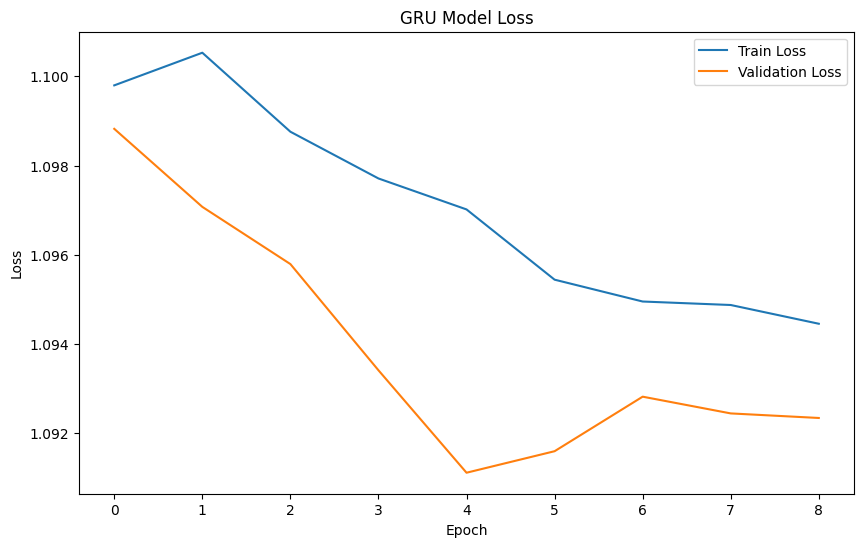

In [36]:
# Plot validation loss of GRU
plt.figure(figsize=(10, 6))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [37]:
# Print classification report of GRU
y_pred_gru = np.argmax(gru_model.predict(X_test_gru), axis=-1)
y_test_gru_labels = np.argmax(y_test_gru, axis=-1)
print(classification_report(y_test_gru_labels, y_pred_gru))

84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       889
           1       0.00      0.00      0.00       889
           2       0.00      0.00      0.00       890

    accuracy                           0.33      2668
   macro avg       0.11      0.33      0.17      2668
weighted avg       0.11      0.33      0.17      2668



<Figure size 800x600 with 0 Axes>

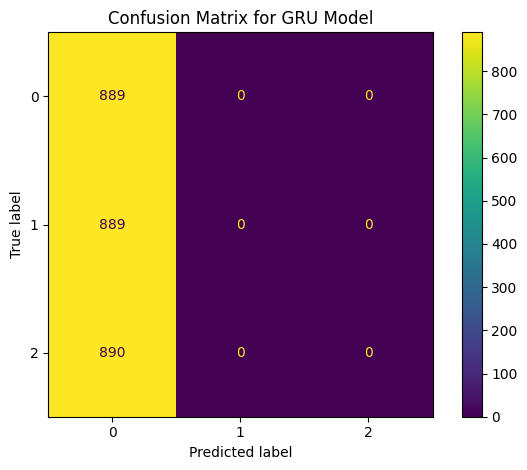

In [38]:
# Confusion Matrix on GRU Model
cm = confusion_matrix(y_test_gru_labels, y_pred_gru)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix for GRU Model')
plt.tight_layout()
plt.grid(False)
plt.show()

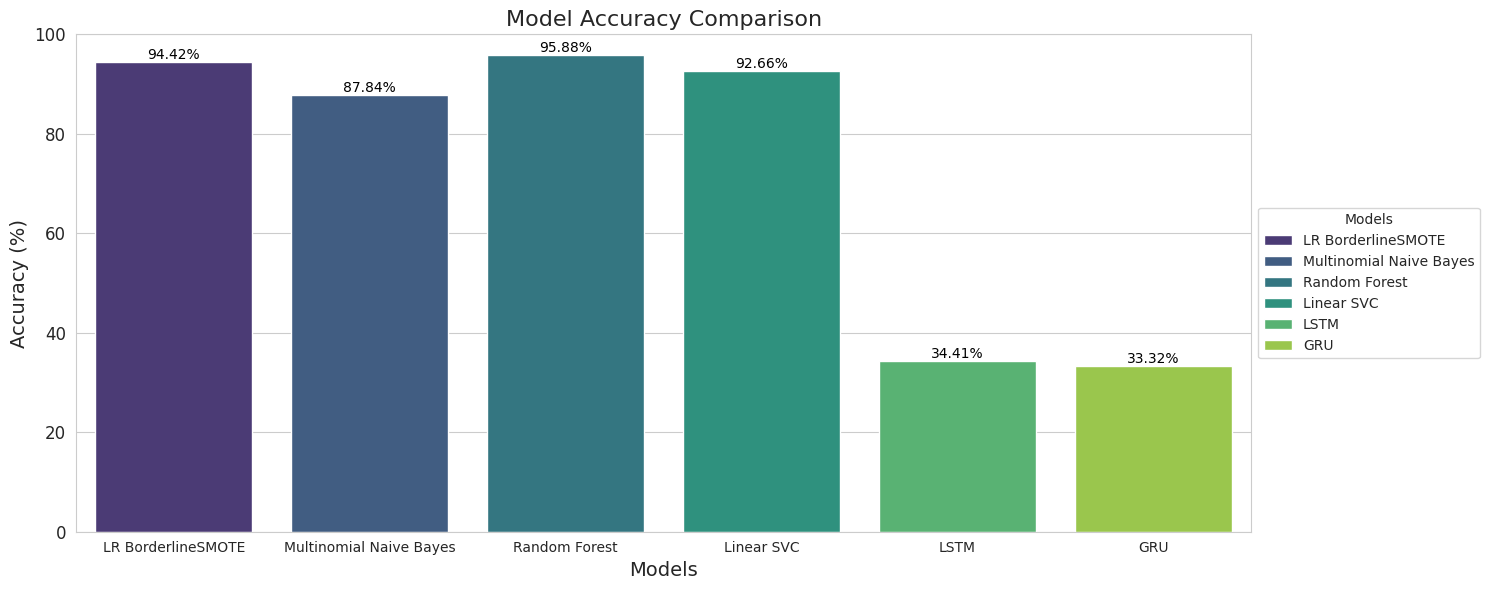

In [39]:
model_accuracies = {
    'LR BorderlineSMOTE': lr_accuracy_borderline_smote,
    'Multinomial Naive Bayes': nb_accuracy,
    'Random Forest': rf_accuracy,
    'Linear SVC': svc_accuracy,
    'LSTM': lstm_accuracy_ros,
    'GRU': gru_accuracy
}

# Convert the dictionary to a DataFrame for easier plotting
accuracy_df = pd.DataFrame({'Model': list(model_accuracies.keys()),
                            'Accuracy': list(model_accuracies.values())})

# Calculate percentage for each model's accuracy
accuracy_df['Accuracy (%)'] = accuracy_df['Accuracy'] * 100

# Create the figure and axes object
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

# Create the bar plot with assigned colors
ax = sns.barplot(x='Model', y='Accuracy (%)', data=accuracy_df,
                 palette='viridis', dodge=False)

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=10, ha='center')
plt.yticks(fontsize=12)
plt.ylim(0, 100)

# Add percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
     (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 5),
                textcoords='offset points')


# Get the handles and labels for the legend
handles = ax.patches  # Get the bar objects directly
labels = accuracy_df['Model'].tolist()  # Get model names for labels

# Create a new legend outside the plot
plt.legend(handles, labels, title='Models',
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Twitter Sentiment Analysis
## Introduction

In this project, we will be performing sentiment analysis on tweets from Twitter using the Tweepy library in Python. We will be using the TextBlob library to perform sentiment analysis on the tweets.

In [ ]:
# Loading the data in .txt
test = pd.read_table('test_62k.txt')
train = pd.read_table('train_150k.txt')

train.head()

,0,Starting back at work today Looks like it'll be raining for the next couple of days
0,1,Sugar levels dropping... munchies setting in. ...
1,1,@karineb22 yeah!!! have a great summer break!
2,1,hannah montana was very good. now going to re...
3,1,"@Mayra326 aww, have fun! I just had my 3D las..."
4,0,Worried about my cat. Took him to the vet and ...


In [ ]:
test.head()

,1,"@justineville ...yeahhh. ) i'm 39 tweets from 1,600!"
0,0,@ApplesnFeathers aww. Poor baby! On your only ...
1,0,@joeymcintyre With my refunded $225 (Australia...
2,0,It's fine. Today sucks just because me those t...
3,0,"Im just chilling on psp and stuff, but sitting..."
4,0,@lisarinna very sad Lisa...she is freeeeeeeeee...


In [ ]:
train.shape, test.shape

((149984, 2), (61997, 2))

In [ ]:
# Rename columns for train and test DataFrames
train.columns = ['N', 'text']
test.columns = ['N', 'text']

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

Training Data:


,N,text
0,1,Sugar levels dropping... munchies setting in. ...
1,1,@karineb22 yeah!!! have a great summer break!
2,1,hannah montana was very good. now going to re...
3,1,"@Mayra326 aww, have fun! I just had my 3D las..."
4,0,Worried about my cat. Took him to the vet and ...


In [ ]:
train['N'].value_counts()

,count
N,
0,75018
1,74966


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149984 entries, 0 to 149983
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   N       149984 non-null  int64 
 1   text    149984 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,@ApplesnFeathers aww. Poor baby! On your only ...
1,0,@joeymcintyre With my refunded $225 (Australia...
2,0,It's fine. Today sucks just because me those t...
3,0,"Im just chilling on psp and stuff, but sitting..."
4,0,@lisarinna very sad Lisa...she is freeeeeeeeee...


In [ ]:
test['N'].value_counts()

,count
N,
1,31028
0,30969


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61997 entries, 0 to 61996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   N       61997 non-null  int64 
 1   text    61997 non-null  object
dtypes: int64(1), object(1)
memory usage: 968.8+ KB


In [ ]:
# Preprocessing on text column of both train and test DataFrames using a define function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

# Apply the preprocess_text function to the 'text' column of both DataFrames
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

Training Data:


,N,text
0,1,sugar levels dropping munchies setting in luck...
1,1,karineb yeah have a great summer break
2,1,hannah montana was very good now going to rea...
3,1,mayra aww have fun i just had my d last week
4,0,worried about my cat took him to the vet and h...


In [ ]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,applesnfeathers aww poor baby on your only rea...
1,0,joeymcintyre with my refunded australian tick...
2,0,its fine today sucks just because me those thi...
3,0,im just chilling on psp and stuff but sitting ...
4,0,lisarinna very sad lisashe is freeeeeeeeeeee a...


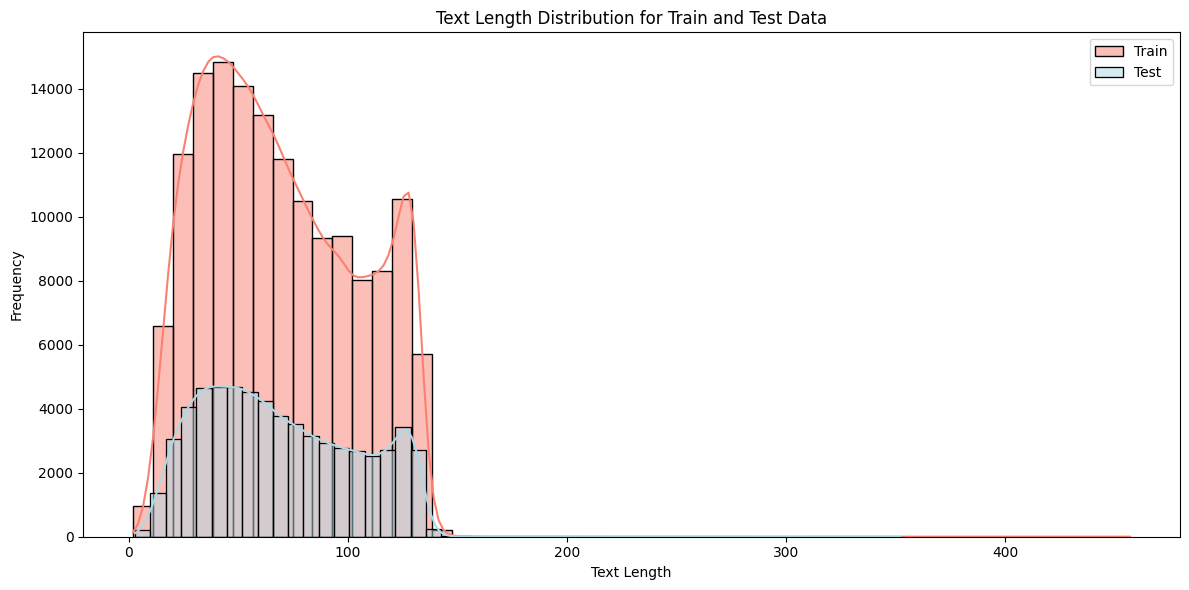

In [ ]:
# Visualize the text length distribution for both train and test DataFrames
plt.figure(figsize=(12, 6))
sns.histplot(train['text'].apply(len), color='salmon', bins=50, kde=True, label='Train')
sns.histplot(test['text'].apply(len), color='lightblue', bins=50, kde=True, label='Test')
plt.title('Text Length Distribution for Train and Test Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

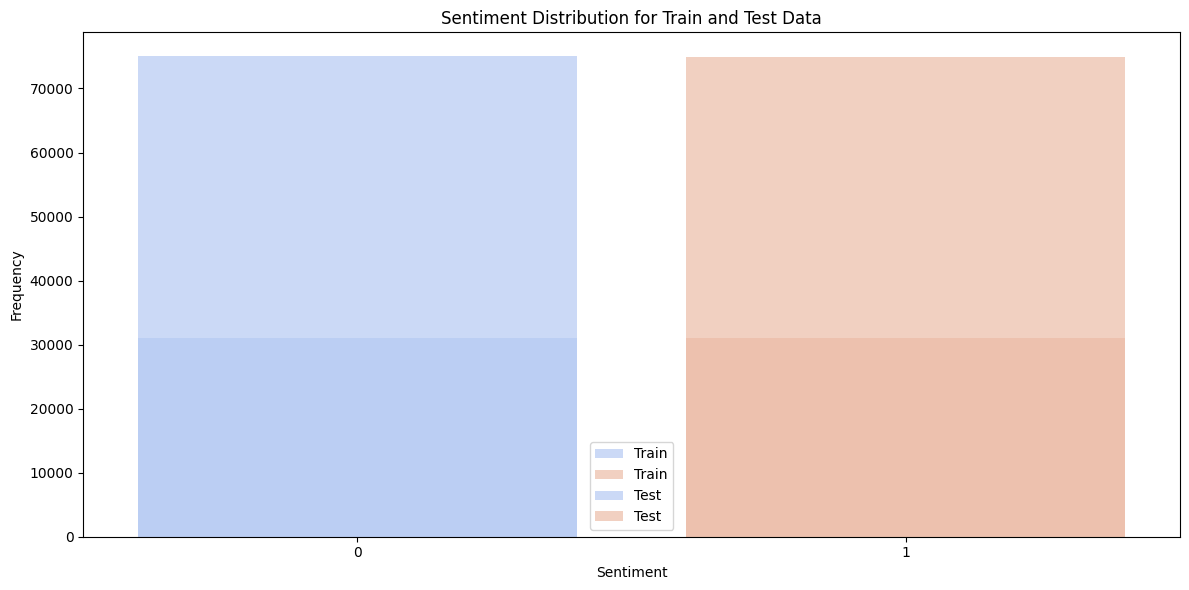

In [ ]:
# Visualize the text column based on the sentiment for both train and test DataFrames
plt.figure(figsize=(12, 6))
sns.countplot(x='N', data=train, palette='coolwarm', label='Train', alpha=0.7)
sns.countplot(x='N', data=test, palette='coolwarm', label='Test', alpha=0.7)
plt.title('Sentiment Distribution for Train and Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Define function to remove punctuation, numbers, stopwords, then tokenize, stem, and lemmatize in lower column for both train and test DataFrames
def preprocess_text(text):
    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing Numbers
    text = re.sub(r'\d+', '', text)

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in (stop_words)])

    # Tokenization
    text = word_tokenize(text)

    # Stemming
    stemmer = nltk.PorterStemmer()
    text = [stemmer.stem(y) for y in text]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(y) for y in text]

    return text

# Apply the preprocess_text function to the 'text' column of both DataFrames
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Training Data:


,N,text
0,1,"[sugar, level, drop, munchi, set, luckili, bla..."
1,1,"[karineb, yeah, great, summer, break]"
2,1,"[hannah, montana, good, go, read, twilight]"
3,1,"[mayra, aww, fun, last, week]"
4,0,"[worri, cat, took, vet, blood, work, etc, norm..."


In [ ]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,"[applesnfeath, aww, poor, babi, real, day]"
1,0,"[joeymcintyr, refund, australian, ticket, pric..."
2,0,"[fine, today, suck, thing, dunno, see]"
3,0,"[im, chill, psp, stuff, sit, pc, also, watch, ..."
4,0,"[lisarinna, sad, lisash, freeeeeeeeeeee, angel..."


In [ ]:
# Perform Word Embedding using CountVectorizer
cv = CountVectorizer(max_features=5000)
X_train = cv.fit_transform(train['text'].apply(lambda x: ' '.join(x))).toarray()
y_train = train['N']
X_test = cv.transform(test['text'].apply(lambda x: ' '.join(x))).toarray()
y_test = test['N']

# Initialize Linear Regression model
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, verbose=1, solver='liblinear', C=0.1)

# Train and evaluate the model
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Display the evaluation metrics
lr_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Logistic Regression Model')
print('-------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

[LibLinear]Logistic Regression Model
-------------------------
Accuracy: 0.7328419117054051
Precision: 0.7500987811920611
Recall: 0.7953783679257445
F1 Score: 0.7720752710037698
AUC-ROC: 0.7649435350881911


---------------------- Confusion Matrix for Logistic Regression Model ----------------------


<Figure size 800x600 with 0 Axes>

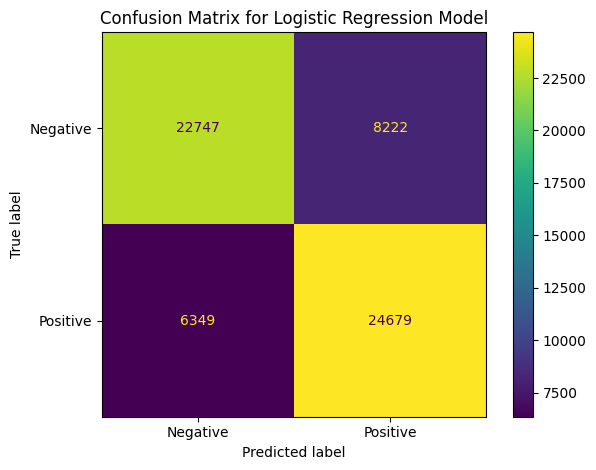

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix for Logistic Regression model
cm = confusion_matrix(y_test, lr.predict(X_test))
print('---------------------- Confusion Matrix for Logistic Regression Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

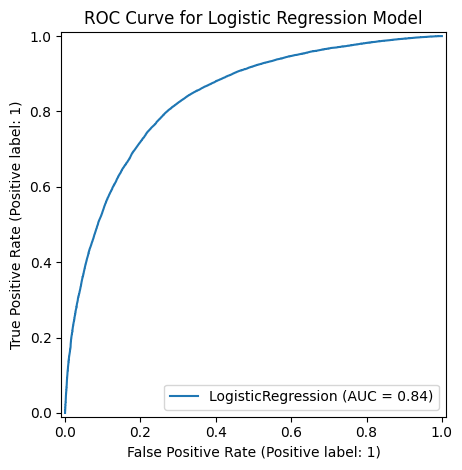

In [ ]:
from sklearn.metrics import RocCurveDisplay

# Plot the ROC curve for Logistic Regression model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr, X_test, y_test)

plt.title('ROC Curve for Logistic Regression Model')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report for Logistic Regression model
print('---------------------- Classification Report of Logistic Regression Model ----------------------')
print(classification_report(y_test, lr.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Logistic Regression Model ----------------------
              precision    recall  f1-score   support

    Negative       0.78      0.73      0.76     30969
    Positive       0.75      0.80      0.77     31028

    accuracy                           0.76     61997
   macro avg       0.77      0.76      0.76     61997
weighted avg       0.77      0.76      0.76     61997

------------------------------------------------------------


In [ ]:
# Initialize Multinomial Naive Bayes model
nb = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)

# Train and evaluate the model
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Display the evaluation metrics
mnb_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Multinomial Naive Bayes Model')
print('-----------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

Multinomial Naive Bayes Model
-----------------------------
Accuracy: 0.7328419117054051
Precision: 0.7606126625734468
Recall: 0.742619569421168
F1 Score: 0.7515084309057108
AUC-ROC: 0.7542249579483378


---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------


<Figure size 800x600 with 0 Axes>

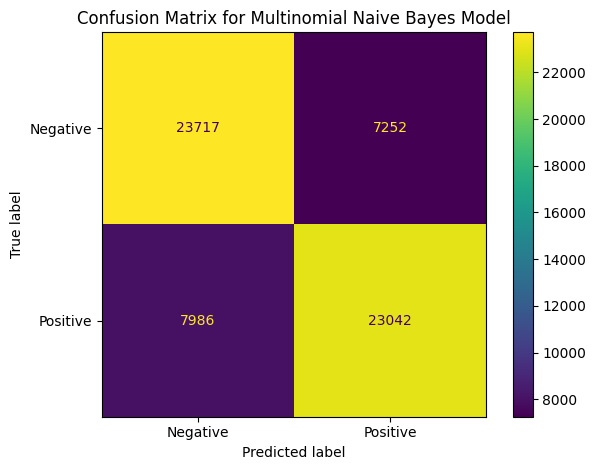

In [ ]:
# Calculate the confusion matrix for Multinomial Naive Bayes model
cm = confusion_matrix(y_test, nb.predict(X_test))
print('---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

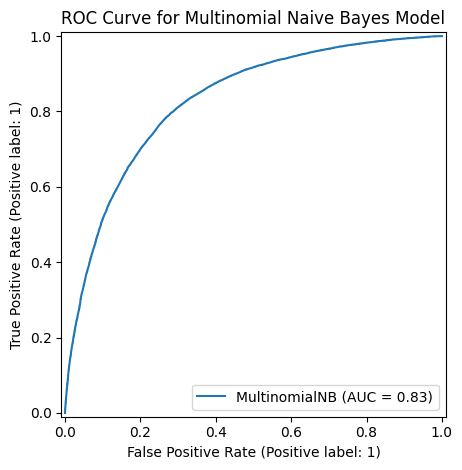

In [ ]:
# Plot the ROC curve for Multinomial Naive Bayes model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(nb, X_test, y_test)

plt.title('ROC Curve for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.show()

In [ ]:
# Classification report for Multinomial Naive Bayes model
print('---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------')
print(classification_report(y_test, nb.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------
              precision    recall  f1-score   support

    Negative       0.75      0.77      0.76     30969
    Positive       0.76      0.74      0.75     31028

    accuracy                           0.75     61997
   macro avg       0.75      0.75      0.75     61997
weighted avg       0.75      0.75      0.75     61997

------------------------------------------------------------


In [ ]:
# Initialize Support Vector Classifier model
svc = LinearSVC(max_iter=10000, random_state=42, C=1)

# Train and evaluate the model
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Display the evaluation metrics
svc_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Linear Support Vector Classifier Model')
print('--------------------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

Linear Support Vector Classifier Model
--------------------------------------
Accuracy: 0.7328419117054051
Precision: 0.7457103013399624
Recall: 0.7927678226118344
F1 Score: 0.7685193863842285
AUC-ROC: 0.7609581629769431


---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------


<Figure size 800x600 with 0 Axes>

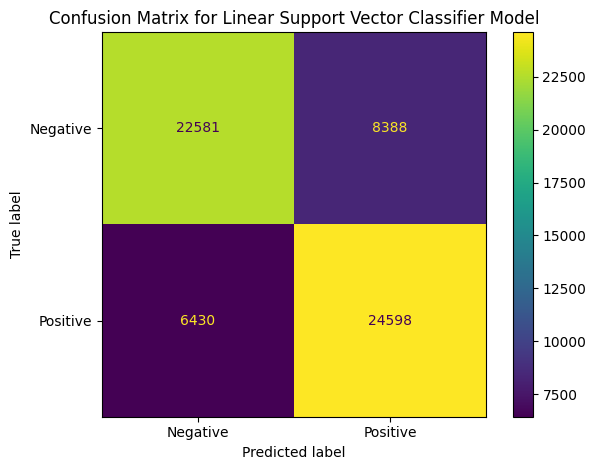

In [ ]:
# Calculate the confusion matrix for Linear Support Vector Classifier model
cm = confusion_matrix(y_test, svc.predict(X_test))
print('---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))

ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

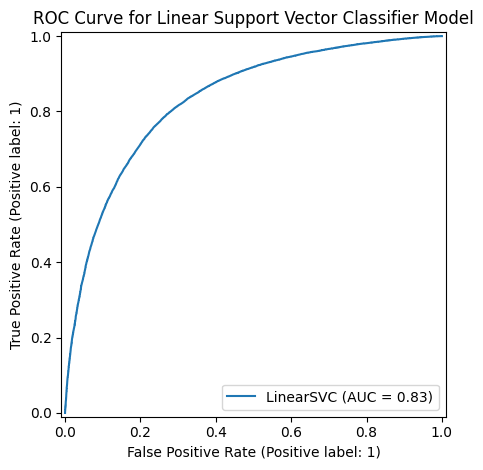

In [ ]:
# Plot the ROC curve for Linear Support Vector Classifier model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(svc, X_test, y_test)

plt.title('ROC Curve for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.show()

In [ ]:
# Classification report for Linear Support Vector Classifier model
print('---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------')
print(classification_report(y_test, svc.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------
              precision    recall  f1-score   support

    Negative       0.78      0.73      0.75     30969
    Positive       0.75      0.79      0.77     31028

    accuracy                           0.76     61997
   macro avg       0.76      0.76      0.76     61997
weighted avg       0.76      0.76      0.76     61997

------------------------------------------------------------


---------------------- Confusion Matrix for Multi-layer Perceptron Model ----------------------


<Figure size 800x600 with 0 Axes>

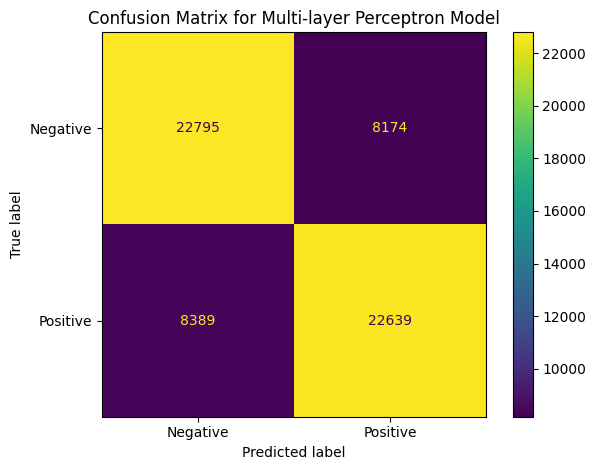

In [ ]:
# Calculate the confusion matrix for Multi-layer Perceptron model
cm = confusion_matrix(y_test, mlp.predict(X_test))
print('---------------------- Confusion Matrix for Multi-layer Perceptron Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Multi-layer Perceptron Model')
plt.tight_layout()
plt.grid(False)
plt.show()

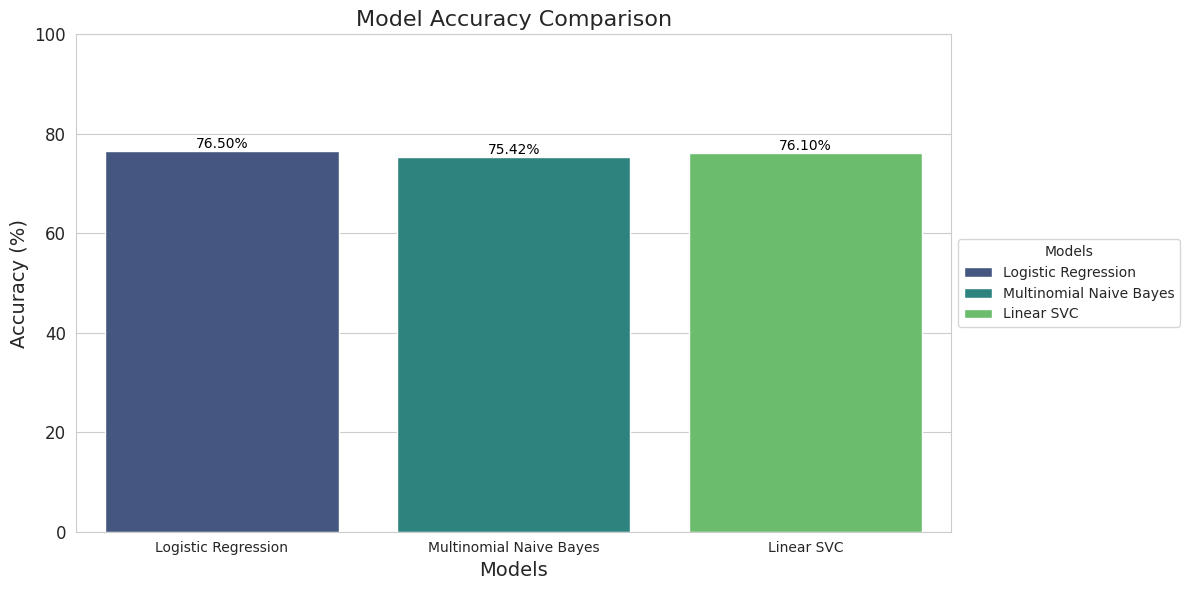

In [ ]:
model_accuracies = {
    'Logistic Regression': lr_accuracy,
    'Multinomial Naive Bayes': mnb_accuracy,
    'Linear SVC': svc_accuracy
}

accuracy_df = pd.DataFrame({'Model': list(model_accuracies.keys()),
                            'Accuracy': list(model_accuracies.values())})

accuracy_df['Accuracy (%)'] = accuracy_df['Accuracy'] * 100

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Model', y='Accuracy (%)', data=accuracy_df, palette='viridis')

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(ha='center', fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(0, 100)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2.,
                                           p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

handles = ax.patches
labels = accuracy_df['Model'].tolist()

# Create a new legend outside the plot
plt.legend(handles, labels, title='Models', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()